# Text Classification


## Libraries

In [ ]:
# install huggingface datasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import pipeline, set_seed
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# PyTorch
import torch
import torch.nn.functional as F

## Text Classification

Load in a huggingface dataset.

In [ ]:
emotions = load_dataset("emotion")
emotions

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
print("Length of the training dataset: ", len(train_ds))

# Get first value of the dataset
print("\nFirst value of the training dataset: ", train_ds[0])
print("\nFirst five values of the training dataset: ", train_ds[:5]['text'])
print("\nColumn Names: ", train_ds.column_names)
print("\nDataset Features: ", train_ds.features)

Length of the training dataset:  16000

First value of the training dataset:  {'text': 'i didnt feel humiliated', 'label': 0}

First five values of the training dataset:  ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']

Column Names:  ['text', 'label']

Dataset Features:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


Formatting HF datasets

In [ ]:
emotions.set_format(type = 'pandas')
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
# correcting the labels
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Looking at class distribution using data visualization.

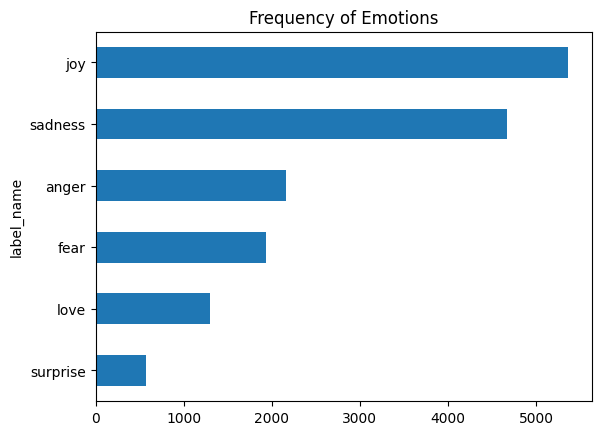

In [ ]:
df['label_name'].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Emotions")
plt.show()

In [ ]:
# Resetting emotions format
emotions.reset_format()

The dataset shown has imbalances,. To remedy, we can:
- Undersample the majority classes
- Oversample the minority classes
- Collect more data from the minority classes

Apply sampling methods **AFTER** developing the test_train_split

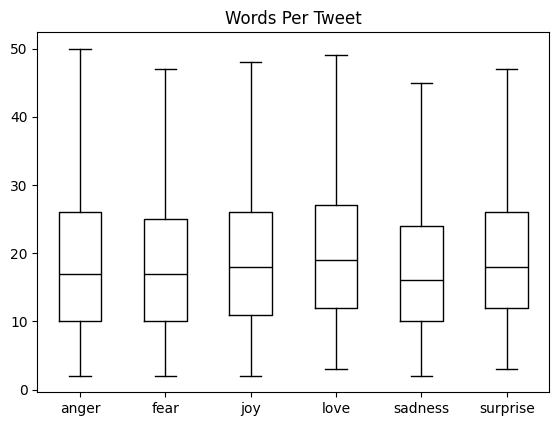

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by = "label_name", grid = False,
           showfliers=False, color = 'black')
plt.suptitle("")    # empty subtitle
plt.xlabel("")    # empty x labels
plt.show()

The boxplots show an average of around 15 words per tweet in the dataset. This is far less than the maximum context size (maximum # of tokens) allowed for the transformer used (DistilBert)-512 tokens.